In [2]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random
import os
from bs4 import BeautifulSoup as bs

In [ ]:
train_dir= '/content/drive/My Drive/kaggle face mask/cropped/training'
val_dir='/content/drive/My Drive/kaggle face mask/cropped/validation'

In [4]:
path='/content/drive/My Drive/kaggle face mask'

In [ ]:
def boxes(obj):

  xmin= int(obj.find('xmin').text)
  xmax=int(obj.find('xmax').text)
  ymin=int(obj.find('ymin').text)
  ymax= int(obj.find('ymax').text)

  return [xmin,xmax,ymin,ymax]

def label(obj):

  if obj.find('name').text == "with_mask":
    return 'mask'
  elif obj.find('name').text == "mask_weared_incorrect":
    return 'incorrect_mask'
  else :
    return 'no_mask'

In [ ]:
coordinates =[]
labels=[]
name=[]
size = []

def gen_list(path):

  annot_list= list(sorted(os.listdir(path+"/annotations")))
  img_list = list(sorted(os.listdir(path+'/images')))
  assert len(img_list)==len(annot_list)
  n=0
  for a in annot_list:
    with open(path+f"/annotations/{a}") as file:
      data = file.read()
      soup = bs(data,"xml")
      objs=soup.find_all('object')
      n+=1
      for o in objs:
        coordinates.append(boxes(o))
        labels.append(label(o))
        name.append(soup.find('filename').text)

In [ ]:
gen_list(path)

In [ ]:
def save_nomask_images(path):
  img_list= list(sorted(os.listdir(path)))
  n=0
  for i in img_list:
    img= cv2.imread(path+f'/{i}')
    detector = MTCNN()
    faces = detector.detect_faces(img)

    for face in faces:
      x,y,w,h=face['box']
      croped_img = img[y:y+h, x:x+w]
      im=Image.fromarray(croped_img)
      im=im.save(train_dir+f'/no_mask/{i}.png')




In [ ]:
save_nomask_images('/content/drive/My Drive/Face_mask_detection/Training/No Mask')

In [ ]:
label_set=list(set(labels))
for l in label_set:
  dirname= path+f"/{l}"
  try: 
    os.mkdir(dirname)
  except FileExistsError:
    print(dirname + " already Exists!")

In [ ]:
import PIL
for i in range(len(name)):
  im= PIL.Image.open(path+f"/images/{name[i]}")
  coordinates[i] = [coordinates[i][0],coordinates[i][2],coordinates[i][1],coordinates[i][3]]
  im= im.crop(coordinates[i])

  if labels[i]=='mask':
    #shutil.copy(path_pst+f"/images/{name[i]}", path+f"/mask/{name[i]}")
    im=im.save(path+f"/mask/{i}.png")
  
  elif labels[i] == "incorrect_mask":
    im=im.save(path+f"/incorrect_mask/{i}.png")
  else:
    im=im.save(path+f"/no_mask/{i}.png")

In [ ]:
os.mkdir(path+'/cropped')
os.mkdir(path+'/cropped/training')
os.mkdir(path+'/cropped/validation')
train_path= os.path.join(path,'cropped','training')
val_path=os.path.join(path,'cropped','validation')
for l in label_set:
  os.mkdir(train_path+f'/{l}')
  os.mkdir(val_path+f'/{l}')

In [ ]:
for l in label_set:
  print(f'{l}: ', len(os.listdir(path+f'/{l}')))

incorrect_mask:  123
mask:  3232
no_mask:  717


In [ ]:
print(len(os.listdir(train_dir+'/no_mask')))

633


In [ ]:
import shutil

def train_test_split(mode=None):

  for mode in ['training','validation']:
    for l in label_set:
        dataset_size= round(len(os.listdir(path+f'/{l}')) * 0.8)
        if mode=='training':
          for i in os.listdir(path+f'/{l}')[:dataset_size]:
            shutil.copy2(path+f'/{l}/{i}',train_path+f'/{l}')
      
        if mode== 'validation':
          for i in os.listdir(path+f'/{l}')[dataset_size:]:
            shutil.copy2(path+f'/{l}/{i}',val_path+f'/{l}')
      

In [ ]:
train_test_split()

In [ ]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              horizontal_flip=True)
train_generator= train_datagen.flow_from_directory(train_dir,
                                                   target_size=(224,224),
                                                   batch_size=100,
                                                   class_mode='binary')

Found 3219 images belonging to 2 classes.


In [ ]:
val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator=val_datagen.flow_from_directory(val_dir,
                                              target_size=(224,224),
                                              batch_size=20,
                                              class_mode='binary')

Found 789 images belonging to 2 classes.


In [ ]:
model= tf.keras.Sequential([
                            tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(224,224,3)),
                            tf.keras.layers.MaxPooling2D(2,2),

                            tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),

                            tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),

                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(512,activation='relu'),
                            tf.keras.layers.Dense(1,activation='sigmoid')


])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1011 (Conv2D)         (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_508 (MaxPoolin (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1012 (Conv2D)         (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_509 (MaxPoolin (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_1013 (Conv2D)         (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_510 (MaxPoolin (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_169 (Flatten)        (None, 43264)            

In [ ]:
optimizer=tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['acc'])

In [ ]:
history=model.fit_generator(train_generator,
                  steps_per_epoch=33,
                  epochs=5,
                  validation_data=val_generator,
                  validation_steps=40,
                  verbose=1)

Epoch 1/5
33/33 [==============================] - 496s 15s/step - loss: 0.4331 - acc: 0.8701 - val_loss: 0.1141 - val_acc: 0.9607
Epoch 2/5
33/33 [==============================] - 155s 5s/step - loss: 0.1305 - acc: 0.9578 - val_loss: 0.1105 - val_acc: 0.9632
Epoch 3/5
33/33 [==============================] - 154s 5s/step - loss: 0.1131 - acc: 0.9643 - val_loss: 0.0869 - val_acc: 0.9708
Epoch 4/5
33/33 [==============================] - 155s 5s/step - loss: 0.1140 - acc: 0.9612 - val_loss: 0.1100 - val_acc: 0.9582
Epoch 5/5
33/33 [==============================] - 154s 5s/step - loss: 0.1127 - acc: 0.9624 - val_loss: 0.0995 - val_acc: 0.9620


In [9]:
pip install mtcnn

     |████████████████████████████████| 2.3MB 3.1MB/s 


In [ ]:
tf.saved_model.save(model,path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/kaggle face mask/assets


In [5]:
load_model=tf.keras.models.load_model(path)

In [6]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [10]:

from PIL import Image
from google.colab.patches import cv2_imshow
from mtcnn.mtcnn import MTCNN

font_scale=1
thickness = 2
red = (255,0,0)
green = (0,255,0)
blue = (0,0,255)
font=cv2.FONT_HERSHEY_SIMPLEX

def face_mask_classifier(filename):
  
  face=tf.keras.preprocessing.image.load_img(filename)
  frame=tf.keras.preprocessing.image.img_to_array(face)
  detector = MTCNN()
  faces = detector.detect_faces(frame)
        
  for f in faces:
      (x, y, w, h) = f['box']          
      croped_img = frame[y:y+h, x:x+w]
      face=tf.keras.preprocessing.image.array_to_img(croped_img).resize((224,224),0)
      face= tf.keras.preprocessing.image.img_to_array(face)
      
      face= np.expand_dims(face,axis=0)

      classes= load_model.predict(face)
            
      if classes[0][0] == 0:
          cv2.putText(frame, "Masked", (x,y - 10), font, font_scale, green, thickness)
          cv2.rectangle(frame, (x, y), (x+w, y+h), green, 2)
      else:
          cv2.putText(frame, "No Mask", (x,y - 10), font, font_scale, red, thickness)
          cv2.rectangle(frame, (x, y), (x+w, y+h), red, 2)
        
  return cv2_imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
    

In [ ]:
face.shape

(1, 224, 224, 3)

<IPython.core.display.Javascript object>

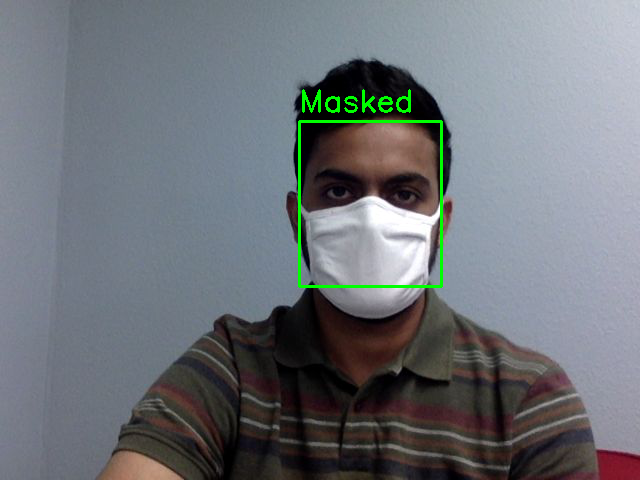

In [11]:
filename= take_photo()
face_mask_classifier(filename)

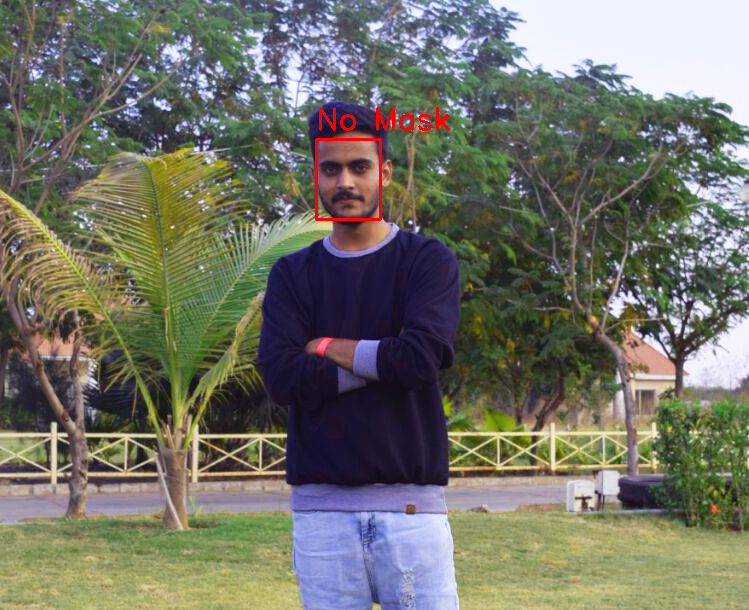

In [ ]:
face_mask_classifier('/content/IMG-20170107-WA0014.png')